# Figure 7 & 8

**Figure 7.** Cross-sections of (a) shortwave, (b) longwave, and (c) net CRH calculated with the ice-optical parameterization of Fu in the WCB ascent region. Panels (d-f) show CRH differences between the ice schemes of Fu and Baum with the general habit mixture (Fu - Baum). Cross-sections are shown at hour 12 and at 3$^{\circ}$ longitude.

**Figure 8.** Impact of ice-optical parameterization on time- and domain-averaged CRH in the three WCB regions. The CRH differences are calculated between the radiative transfer calculations with the ice schemes of Fu and Baum (Fu - Baum). The differences between Fu and Baum with general habit mixture (ghm), solid column (sc), and rough-aggregated (ra) habits are shown with solid lines, dashed lines, and dotted lines, as is indicated in the legend.

---
@ Behrooz Keshtgar, KIT 2023

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import colorlegend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as mcolors
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.23.5
matplotlib: 3.3.0


**Since datasets are large, I use DASK to speed up my analysis**

In [3]:
import dask
from dask.distributed import Client, progress, wait
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
client = Client()
client

<Client: 'tcp://127.0.0.1:42241' processes=16 threads=256, memory=252.72 GB>

## 2- Loading datasets

In [4]:
# Dictionary for loading datasets for the 4 simulations
simdict = {
         'LC1-LES-471x667km-lon25-lat40-300m-0006' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon40-lat44-300m-0003' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon30-lat53-300m-0005' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon50-lat48-300m-0004' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
          }

In [5]:
# all libradtrn simulation using ice parametrization of Fu and Baum
def load_simulations(num):
    ds_list = []
    sim = list(simdict.keys())[num]
    print('Working on loading data for', sim)
    path = '/work/bb1135/icon_output/'+sim+'/input4libradtran/libradtran/output_netcdf/'
    for solver in ['ipa3d']:
        # loop over sources (thermal/solar)
        for source in ['thermal','solar']:
            # loop over sim types
            for nsim in ['01','02','03','04']: # different ice param
                ds = xr.open_mfdataset(path+'ds_librad2_05T*_'+source+'_'+solver+'_'+nsim+'.nc',concat_dim='time',combine='nested',
                                           chunks={'height': 50},parallel=True).isel(height=slice(0,140))
                ds.attrs['sim_name'] = 'ds_librad_'+source+'_'+solver+'_'+nsim+''
                ds_list.append(ds)
    return ds_list                
#-------------------------------------
ds_lib2=load_simulations(1)
ds_lib3=load_simulations(2)
ds_lib4=load_simulations(3)

## height values at full-levels
z_ifc = xr.open_dataset('/work/bb1135/icon_output/LC1-LES-471x667km-lon40-lat44-300m-0003/icon-atm3d_ML_20220105T120033Z.nc')["z_ifc"].isel(ncells=20000)
z_fl  = ((z_ifc - z_ifc.diff('height_3')/2).values)*1e-3 # km
# select between index 0:140
z_fl2  = z_fl[10:150][::-1]

Working on loading data for LC1-LES-471x667km-lon40-lat44-300m-0003
Working on loading data for LC1-LES-471x667km-lon30-lat53-300m-0005
Working on loading data for LC1-LES-471x667km-lon50-lat48-300m-0004


## 3- Average profiles of CRH

In [6]:
# excluding boundaries and takin domain average
for i in range(8):
    ds_lib2[i]['ddt_radlw_mean'] = ds_lib2[i]['ddt_radlw'].isel(lon=slice(10,ds_lib2[i].lon.size-10),lat=slice(5,ds_lib2[i].lat.size-5)).mean(dim=['lat','lon','time']).values
    ds_lib3[i]['ddt_radlw_mean'] = ds_lib3[i]['ddt_radlw'].isel(lon=slice(10,ds_lib3[i].lon.size-10),lat=slice(5,ds_lib3[i].lat.size-5)).mean(dim=['lat','lon','time']).values
    ds_lib4[i]['ddt_radlw_mean'] = ds_lib4[i]['ddt_radlw'].isel(lon=slice(10,ds_lib4[i].lon.size-10),lat=slice(5,ds_lib4[i].lat.size-5)).mean(dim=['lat','lon','time']).values

## 4- Plot

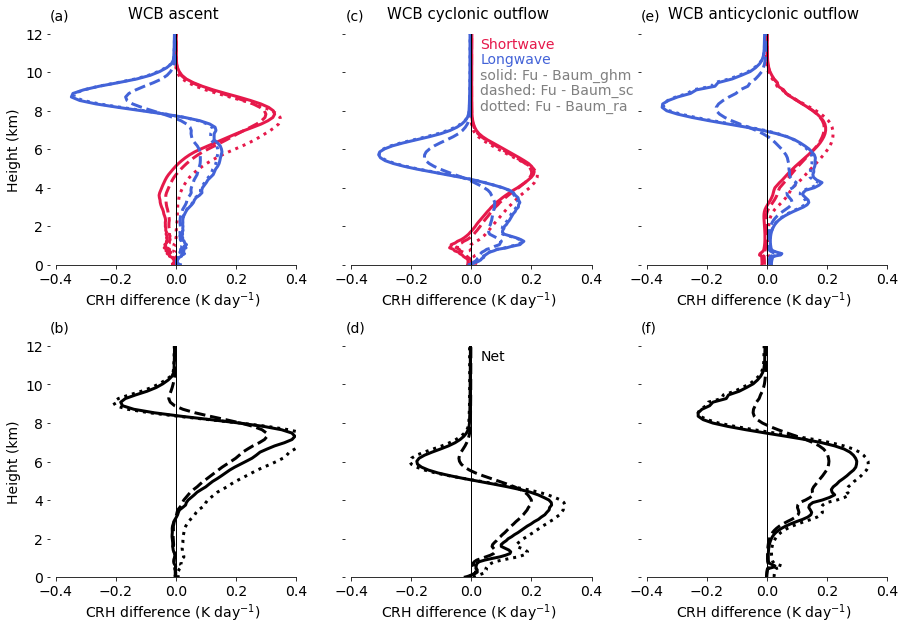

In [7]:
# plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
i = 0

for ax in axes.flat:
    ax.tick_params(labelsize=14)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    
    if i == 0:
        # SW diff
        difflw_1 = ds_lib2[0]['ddt_radlw_mean'].values - ds_lib2[1]['ddt_radlw_mean'].values
        difflw_2 = ds_lib2[0]['ddt_radlw_mean'].values - ds_lib2[2]['ddt_radlw_mean'].values
        difflw_3 = ds_lib2[0]['ddt_radlw_mean'].values - ds_lib2[3]['ddt_radlw_mean'].values
        # LW diff
        diffsw_1 = ds_lib2[4]['ddt_radlw_mean'].values - ds_lib2[5]['ddt_radlw_mean'].values
        diffsw_2 = ds_lib2[4]['ddt_radlw_mean'].values - ds_lib2[6]['ddt_radlw_mean'].values
        diffsw_3 = ds_lib2[4]['ddt_radlw_mean'].values - ds_lib2[7]['ddt_radlw_mean'].values
        #total_diff1 = difflw_1 + diffsw_1
        #total_diff2 = difflw_2 + diffsw_2
        #total_diff3 = difflw_3 + diffsw_3
        
        ax.set_title('WCB ascent', fontsize=15,pad=15)
        ax.plot(diffsw_1,z_fl2,color='#e6194B',lw=3)#,label='Fu - Baum_ghm')
        ax.plot(diffsw_2,z_fl2,color='#e6194B',linestyle='dashed',lw=3)#,label='Fu - Baum_sc')
        ax.plot(diffsw_3,z_fl2,color='#e6194B',linestyle='dotted',lw=3)#,label='Fu - Baum_rg')

        ax.plot(difflw_1,z_fl2,color='#4363d8',lw=3)
        ax.plot(difflw_2,z_fl2,color='#4363d8',linestyle='dashed',lw=3)
        ax.plot(difflw_3,z_fl2,color='#4363d8',linestyle='dotted',lw=3)
        
        #ax.legend([("#e6194B","solid"), ("#e6194B","dashed"), ("#e6194B","dotted")], ['Fu - Baum_ghm', "Fu - Baum_sc","Fu - Baum_rg"],
        #   handler_map={tuple: AnyObjectHandler()},loc=6,fontsize=11,frameon=False)
        
        #ax.plot(total_diff1,z_fl2,color='#000000',label='Total',alpha=0.5)
        #ax.plot(total_diff2,z_fl2,color='#000000',linestyle='dashed',label='Total',alpha=0.5)
        #ax.plot(total_diff3,z_fl2,color='#000000',linestyle='dotted',label='Total',alpha=0.5)
        #ax.legend(loc=6)
        #lg=colorlegend.color_legend(ax,loc=2,fsize=14)
        
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        ax.set_ylabel('Height (km)', fontsize=14)
        ax.set_xlabel('CRH difference (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        ax.text(0.0, 1.06, '(a)', transform=ax.transAxes, 
            size=14)
        
        ax.set_ylim([0,12])
        
        ax.spines['bottom'].set_bounds(-0.4,0.4)
        ax.set_xticks(np.linspace(-0.4,0.4,5))
        ax.set_xlim([-0.42,0.4])
    
    if i == 1:
        # SW diff
        difflw_1 = ds_lib3[0]['ddt_radlw_mean'].values - ds_lib3[1]['ddt_radlw_mean'].values
        difflw_2 = ds_lib3[0]['ddt_radlw_mean'].values - ds_lib3[2]['ddt_radlw_mean'].values
        difflw_3 = ds_lib3[0]['ddt_radlw_mean'].values - ds_lib3[3]['ddt_radlw_mean'].values
        # LW diff
        diffsw_1 = ds_lib3[4]['ddt_radlw_mean'].values - ds_lib3[5]['ddt_radlw_mean'].values
        diffsw_2 = ds_lib3[4]['ddt_radlw_mean'].values - ds_lib3[6]['ddt_radlw_mean'].values
        diffsw_3 = ds_lib3[4]['ddt_radlw_mean'].values - ds_lib3[7]['ddt_radlw_mean'].values

        
        ax.set_title('WCB cyclonic outflow', fontsize=15,pad=15)
        ax.plot(diffsw_1,z_fl2,color='#e6194B',lw=3)#,label='Fu - Baum_ghm')
        ax.plot(diffsw_2,z_fl2,color='#e6194B',linestyle='dashed',lw=3)#,label='Fu - Baum_sc')
        ax.plot(diffsw_3,z_fl2,color='#e6194B',linestyle='dotted',lw=3)#,label='Fu - Baum_rg')

        ax.plot(difflw_1,z_fl2,color='#4363d8',lw=3)
        ax.plot(difflw_2,z_fl2,color='#4363d8',linestyle='dashed',lw=3)
        ax.plot(difflw_3,z_fl2,color='#4363d8',linestyle='dotted',lw=3)
        
        total_diff1 = difflw_1 + diffsw_1
        total_diff2 = difflw_2 + diffsw_2
        total_diff3 = difflw_3 + diffsw_3
        
        #ax.plot(total_diff1,z_fl2,color='#000000',label='Total',alpha=0.5)
        #ax.plot(total_diff2,z_fl2,color='#000000',linestyle='dashed',label='Total',alpha=0.5)
        #ax.plot(total_diff3,z_fl2,color='#000000',linestyle='dotted',label='Total',alpha=0.5)
        #ax.legend(loc=2,fontsize=11,frameon=False)

        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        #ax.set_ylabel('Height (km)', fontsize=14)
        ax.set_xlabel('CRH difference (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        ax.text(0.0, 1.06, '(c)', transform=ax.transAxes, 
            size=14)
        
        ax.set_ylim([0,12])
        ax.set_yticklabels([])
        
        ax.spines['bottom'].set_bounds(-0.4,0.4)
        ax.set_xticks(np.linspace(-0.4,0.4,5))
        ax.set_xlim([-0.42,0.4])
        
        ax.text(0.03, 11.8, "Shortwave", color="#e6194B", size=14, ha="left", va="top")
        ax.text(0.03, 11, "Longwave", color='#4363d8', size=14, ha="left", va="top")
        #ax.text(0.03, 10.25, "Total", color='#000000', size=14, va="top",alpha=0.5)
        ax.text(0.03, 10.2, "solid: Fu - Baum_ghm", color="gray", size=14, va="top")
        ax.text(0.03, 9.4, "dashed: Fu - Baum_sc", color="gray", size=14, va="top")
        ax.text(0.03, 8.6, "dotted: Fu - Baum_ra", color="gray", size=14, va="top")
        
    if i == 2:
        # SW diff
        difflw_1 = ds_lib4[0]['ddt_radlw_mean'].values - ds_lib4[1]['ddt_radlw_mean'].values
        difflw_2 = ds_lib4[0]['ddt_radlw_mean'].values - ds_lib4[2]['ddt_radlw_mean'].values
        difflw_3 = ds_lib4[0]['ddt_radlw_mean'].values - ds_lib4[3]['ddt_radlw_mean'].values
        # LW diff
        diffsw_1 = ds_lib4[4]['ddt_radlw_mean'].values - ds_lib4[5]['ddt_radlw_mean'].values
        diffsw_2 = ds_lib4[4]['ddt_radlw_mean'].values - ds_lib4[6]['ddt_radlw_mean'].values
        diffsw_3 = ds_lib4[4]['ddt_radlw_mean'].values - ds_lib4[7]['ddt_radlw_mean'].values

        
        ax.set_title('WCB anticyclonic outflow', fontsize=15,pad=15)
        ax.plot(diffsw_1,z_fl2,color='#e6194B',lw=3)#,label='Fu - Baum_ghm')
        ax.plot(diffsw_2,z_fl2,color='#e6194B',linestyle='dashed',lw=3)#,label='Fu - Baum_sc')
        ax.plot(diffsw_3,z_fl2,color='#e6194B',linestyle='dotted',lw=3)#,label='Fu - Baum_rg')

        ax.plot(difflw_1,z_fl2,color='#4363d8',lw=3)
        ax.plot(difflw_2,z_fl2,color='#4363d8',linestyle='dashed',lw=3)
        ax.plot(difflw_3,z_fl2,color='#4363d8',linestyle='dotted',lw=3)
        
        total_diff1 = difflw_1 + diffsw_1
        total_diff2 = difflw_2 + diffsw_2
        total_diff3 = difflw_3 + diffsw_3
        
        #ax.plot(total_diff1,z_fl2,color='#000000',label='Total',alpha=0.5)
        #ax.plot(total_diff2,z_fl2,color='#000000',linestyle='dashed',label='Total',alpha=0.5)
        #ax.plot(total_diff3,z_fl2,color='#000000',linestyle='dotted',label='Total',alpha=0.5)
        
        #ax.legend(loc=2,fontsize=11,frameon=False)

        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        #ax.set_ylabel('Height (km)', fontsize=14)
        ax.set_xlabel('CRH difference (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        ax.text(0.0, 1.06, '(e)', transform=ax.transAxes, 
            size=14)
        
        ax.set_ylim([0,12])
        ax.set_yticklabels([])
        
        ax.spines['bottom'].set_bounds(-0.4,0.4)
        ax.set_xticks(np.linspace(-0.4,0.4,5))
        ax.set_xlim([-0.42,0.4])
        
        
    if i == 3:
        # SW diff
        difflw_1 = ds_lib2[0]['ddt_radlw_mean'].values - ds_lib2[1]['ddt_radlw_mean'].values
        difflw_2 = ds_lib2[0]['ddt_radlw_mean'].values - ds_lib2[2]['ddt_radlw_mean'].values
        difflw_3 = ds_lib2[0]['ddt_radlw_mean'].values - ds_lib2[3]['ddt_radlw_mean'].values
        # LW diff
        diffsw_1 = ds_lib2[4]['ddt_radlw_mean'].values - ds_lib2[5]['ddt_radlw_mean'].values
        diffsw_2 = ds_lib2[4]['ddt_radlw_mean'].values - ds_lib2[6]['ddt_radlw_mean'].values
        diffsw_3 = ds_lib2[4]['ddt_radlw_mean'].values - ds_lib2[7]['ddt_radlw_mean'].values
        total_diff1 = difflw_1 + diffsw_1
        total_diff2 = difflw_2 + diffsw_2
        total_diff3 = difflw_3 + diffsw_3
        
        ax.plot(total_diff1,z_fl2,color='#000000',label='Total',lw=3)
        ax.plot(total_diff2,z_fl2,color='#000000',linestyle='dashed',label='Total',lw=3)
        ax.plot(total_diff3,z_fl2,color='#000000',linestyle='dotted',label='Total',lw=3)
        #ax.legend(loc=6)
        #lg=colorlegend.color_legend(ax,loc=2,fsize=14)
        
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        ax.set_ylabel('Height (km)', fontsize=14)
        ax.set_xlabel('CRH difference (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        ax.text(0.0, 1.06, '(b)', transform=ax.transAxes, 
            size=14)
        
        ax.set_ylim([0,12])
        
        ax.spines['bottom'].set_bounds(-0.4,0.4)
        ax.set_xticks(np.linspace(-0.4,0.4,5))
        ax.set_xlim([-0.42,0.4])
        
    if i == 4:
        # SW diff
        difflw_1 = ds_lib3[0]['ddt_radlw_mean'].values - ds_lib3[1]['ddt_radlw_mean'].values
        difflw_2 = ds_lib3[0]['ddt_radlw_mean'].values - ds_lib3[2]['ddt_radlw_mean'].values
        difflw_3 = ds_lib3[0]['ddt_radlw_mean'].values - ds_lib3[3]['ddt_radlw_mean'].values
        # LW diff
        diffsw_1 = ds_lib3[4]['ddt_radlw_mean'].values - ds_lib3[5]['ddt_radlw_mean'].values
        diffsw_2 = ds_lib3[4]['ddt_radlw_mean'].values - ds_lib3[6]['ddt_radlw_mean'].values
        diffsw_3 = ds_lib3[4]['ddt_radlw_mean'].values - ds_lib3[7]['ddt_radlw_mean'].values
        total_diff1 = difflw_1 + diffsw_1
        total_diff2 = difflw_2 + diffsw_2
        total_diff3 = difflw_3 + diffsw_3
        
        ax.plot(total_diff1,z_fl2,color='#000000',label='Total',lw=3)
        ax.plot(total_diff2,z_fl2,color='#000000',linestyle='dashed',label='Total',lw=3)
        ax.plot(total_diff3,z_fl2,color='#000000',linestyle='dotted',label='Total',lw=3)

        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        ax.set_xlabel('CRH difference (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        ax.text(0.0, 1.06, '(d)', transform=ax.transAxes, 
            size=14)
        ax.set_yticklabels([])
        
        ax.set_ylim([0,12])
        ax.text(0.03, 11.8, "Net", color="#000000", size=14, ha="left", va="top")
        
        ax.spines['bottom'].set_bounds(-0.4,0.4)
        ax.set_xticks(np.linspace(-0.4,0.4,5))
        ax.set_xlim([-0.42,0.4])
        
    if i == 5:
        # SW diff
        difflw_1 = ds_lib4[0]['ddt_radlw_mean'].values - ds_lib4[1]['ddt_radlw_mean'].values
        difflw_2 = ds_lib4[0]['ddt_radlw_mean'].values - ds_lib4[2]['ddt_radlw_mean'].values
        difflw_3 = ds_lib4[0]['ddt_radlw_mean'].values - ds_lib4[3]['ddt_radlw_mean'].values
        # LW diff
        diffsw_1 = ds_lib4[4]['ddt_radlw_mean'].values - ds_lib4[5]['ddt_radlw_mean'].values
        diffsw_2 = ds_lib4[4]['ddt_radlw_mean'].values - ds_lib4[6]['ddt_radlw_mean'].values
        diffsw_3 = ds_lib4[4]['ddt_radlw_mean'].values - ds_lib4[7]['ddt_radlw_mean'].values
        total_diff1 = difflw_1 + diffsw_1
        total_diff2 = difflw_2 + diffsw_2
        total_diff3 = difflw_3 + diffsw_3
        
        ax.plot(total_diff1,z_fl2,color='#000000',label='Total',lw=3)
        ax.plot(total_diff2,z_fl2,color='#000000',linestyle='dashed',label='Total',lw=3)
        ax.plot(total_diff3,z_fl2,color='#000000',linestyle='dotted',label='Total',lw=3)

        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        ax.set_xlabel('CRH difference (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        ax.text(0.0, 1.06, '(f)', transform=ax.transAxes, 
            size=14)
        ax.set_yticklabels([])
        
        ax.set_ylim([0,12])
        
        ax.spines['bottom'].set_bounds(-0.4,0.4)
        ax.set_xticks(np.linspace(-0.4,0.4,5))
        ax.set_xlim([-0.42,0.4])    
        
    i = i + 1    
    
fig.subplots_adjust(wspace=0.2,hspace=0.35) 

plt.savefig('figure8.pdf', bbox_inches = 'tight')
plt.savefig('figure8.png', bbox_inches = 'tight',dpi=300)

## 5- longitude-latitude plots, WCB ascent region

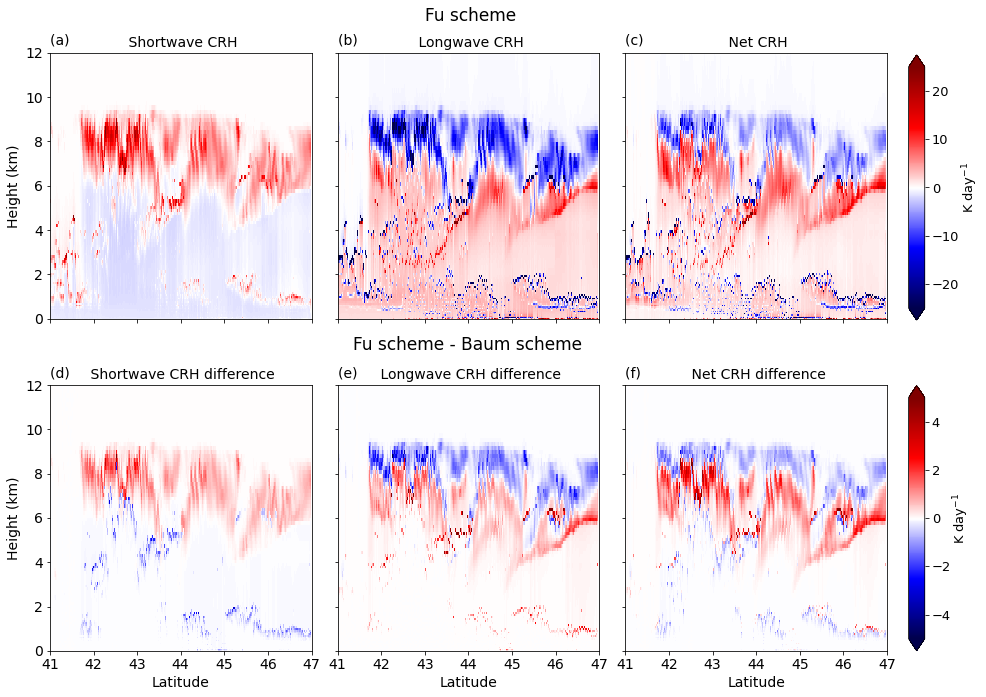

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 11))
i = 0

## coordinates for plotting
lat = np.linspace(41,47,1686)
lon = np.linspace(-1,5,2064)

for ax in axes.flat:
    ax.tick_params(labelsize=14)
    ax.set_ylim([0,12])
    
    if i == 0:
        sw = ds_lib2[4].ddt_radlw.isel(time=4,lon=1050)
        im0 = ax.pcolor(lat,z_fl2,sw.transpose(),cmap='seismic',vmin=-25,vmax=25)
        ax.set_title(' Shortwave CRH', fontsize=14)
        ax.set_xticklabels([])
        ax.set_ylabel('Height (km)', fontsize=14)
        ax.text(0.0, 1.03, '(a) ', transform=ax.transAxes, 
            size=14)
        
    if i == 1:
        lw = ds_lib2[0].ddt_radlw.isel(time=4,lon=1050)
        im = ax.pcolor(lat,z_fl2,lw.transpose(),cmap='seismic',vmin=-25,vmax=25)
        ax.set_title(' Longwave CRH', fontsize=14)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(b) ', transform=ax.transAxes, 
            size=14)
        
        
    if i == 2:
        nt = (ds_lib2[4].ddt_radlw + ds_lib2[0].ddt_radlw).isel(time=4,lon=1050)
        im = ax.pcolor(lat,z_fl2,nt.transpose(),cmap='seismic',vmin=-25,vmax=25)
        ax.set_title(' Net CRH', fontsize=14)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(c) ', transform=ax.transAxes, 
            size=14)
        
    ####################
    
    if i == 3:
        diffsw = (ds_lib2[4].ddt_radlw - ds_lib2[5].ddt_radlw).isel(time=4,lon=1050)
        im1 = ax.pcolor(lat,z_fl2,diffsw.transpose(),cmap='seismic',vmin=-5,vmax=5)
        ax.set_xlabel('Latitude', fontsize=14)
        ax.set_title(' Shortwave CRH difference', fontsize=14)
        ax.set_ylabel('Height (km)', fontsize=14)
        ax.text(0.0, 1.03, '(d) ', transform=ax.transAxes, 
            size=14)
        
    if i == 4:
        difflw = (ds_lib2[0].ddt_radlw - ds_lib2[1].ddt_radlw).isel(time=4,lon=1050)
        im = ax.pcolor(lat,z_fl2,difflw.transpose(),cmap='seismic',vmin=-5,vmax=5)
        ax.set_xlabel('Latitude', fontsize=14)
        ax.set_title(' Longwave CRH difference', fontsize=14)
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(e) ', transform=ax.transAxes, 
            size=14)
        
        
    if i == 5:
        nt1 = (ds_lib2[4].ddt_radlw + ds_lib2[0].ddt_radlw).isel(time=4,lon=1050)
        nt2 = (ds_lib2[5].ddt_radlw + ds_lib2[1].ddt_radlw).isel(time=4,lon=1050)
        diffnt = nt1 - nt2
        im = ax.pcolor(lat,z_fl2,diffnt.transpose(),cmap='seismic',vmin=-5,vmax=5)
        ax.set_xlabel('Latitude', fontsize=14)
        ax.set_title(' Net CRH difference', fontsize=14)
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(f) ', transform=ax.transAxes, 
            size=14)
        
    i = i + 1
    
fig.subplots_adjust(wspace=0.1,hspace=0.25) 

cb_ax = fig.add_axes([0.92, 0.5425, 0.015, 0.335]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im0,cax=cb_ax,orientation='vertical',shrink=0.95,extend='both')
cbar.set_label(label='K day$^{-1}$', size='13',labelpad=1)
cbar.ax.tick_params(labelsize=13)

cb_ax = fig.add_axes([0.92, 0.125, 0.015, 0.335]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im1,cax=cb_ax,orientation='vertical',shrink=0.95,extend='both')
cbar.set_label(label='K day$^{-1}$', size='13',labelpad=1)
cbar.ax.tick_params(labelsize=13)

plt.text(.512, 0.505, 'Fu scheme - Baum scheme', transform=fig.transFigure, horizontalalignment='center',fontsize=17)
plt.text(.514, 0.92, 'Fu scheme', transform=fig.transFigure, horizontalalignment='center',fontsize=17)

#plt.savefig('figure7.pdf', bbox_inches = 'tight')
plt.savefig('figure7.png', bbox_inches = 'tight',dpi=300)

In [20]:
client.close()